# E5 - Fourier interpolation


## 1. Introduction

#### Technical background
Fourier interpolation stochastic optical fluctuation imaging ([fSOFI](https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-23-12-16154&id=320224)) solves the finite pixelation problem of SOFI by adding virtual pixels using Fourier transforms. We have implemented the Fourier interpolation method in \textit{pysofi} to allow for fSOFI analysis in the SOFI analysis pipeline. We create the forward Fourier transform using the origianl input image size, and create the inverse Fourier transform matrix to include the extra interpolation position coordinates without 'zero-padding' the spectrum image, reducing the memory requirement for the interpolation during the computation process. This method is adopted from this [MATLAB version](https://github.com/xiyuyi/xy_fInterp_forTIFF). 


#### What's included in this notebook
This notebook demonstrates how to perfrom Fourier interpolation of a tiff stack in the pysofi package with two options. One option (section 3) is to perfrom Fourier interpolation through the PysofiData class and is useful when one wants to use it in the existing SOFI analysis workflow we implemented in the PysofiData class. The second option (section 4) is to use it by directly importing and using the relevant function module (finterp.py). This option is useful when you would like to perform the Fourier interpolation as a standalone processing step in your own data analysis workflow. 

#### Relevant dataset
The datafiles used in the examples (Jupyter Notebooks) are included in the *exampledata* folder in the **pysofi** repository. In this notebook, we use an experimental dataset from our previous work [1]. The sample is a Hela cell transfected with Dronpa-C12 (fluorescent protein) fused to β-Actin. Details of the experimental procedure are availble in the relevant pulbication [1]. We only used 200 frames in this demonstration ('Block10.tif') to demonstrate the Fourier interpolation for a .tiff stack. 


## 2. Import all the tools
Before we begin, let's first import all the relevant packages and modules.

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from skimage.external import tifffile as tiff
from pysofi import pysofi, finterp
from pysofi import visualization as v
%matplotlib inline


Loading BokehJS ...

## 3. Use <code>PysofiData</code> class for the Fourier interpolation 

Here we demonstrate hwo to perform Fourier interpolation using the workflow implemented in the <code>PysofiData</code> class.

#### 3.1. Load the data
First, we load the data into the <code>PysofiData</code> class.

In [2]:
# load data into PysofiData object
filepath = '../sampledata'
filename = 'Block10.tif'
d = pysofi.PysofiData(filepath, filename) 

#### 3.2. Perfrom the Fourier interpolation

<code>PysofiData.finterp_tiffstack</code> is a method of the PysofiData object that carries out Fourier interpolation on the video directly. Note that this step may still consume large memory or time, depending on the tiff file (dimensions, frame number) and the number of new pixels generated. 

In the example below, we are interpolating the .tiff stack for the initial 100 frames, and saved out the interpolated images as separate .tiff stacks. Two interpolation factors are specifiec, and we will obtain two separate interpolated .tiff stacks. The file names of the interpolated .tiff stacks are the original .tiff stack name appended with the interpolation factor informatiln. For example, in this case, the two interpoalted .tiff stack will be <code>block10_InterpNum2.tiff</code> and <code>block10_InterpNum4.tiff</code> respectively.

In [3]:
d.finterp_tiffstack(interp_num_lst=[2,4], frames=[0,100], save_option=True, return_option=False)

Calculating interpolation factor = 2...
[==============================] 100.0%

Calculating interpolation factor = 4...
[==============================] 100.0%



As we can see from the example above, we can pass a few parameters to <code>finterp_tiffstack</code>:
+ <code>interp_num_lst</code>: a list of interpolation factors (integers) that is relevant to the fold of pixels of the interpolated images as compared to the input image. Please note that the dimensions of the interpolated image is not a exact integer fold of the original dimensions (although close) due to the edge effect. Suppose the original dimensions are $xdim$ and $ydim$ respectively, and the interpolation factor is $f$: After Fourier interpolation, the dimensions will become $(xdim-1)*f + 1$ and $(ydim-1)*f + 1$. For example, the interpolation result of a $10\times10$ matrix with an interpolation factor of 3, would yield a $28\times28$ matrix. Note that this <code>interp_num_lst</code> parameter is a list of integers, meaning that a series of interpolated .tiff movies will be generated, each corresponding to one interpolation factor defined in the list. Using a list is useful when various of interpolation factors are to be explored. If only one interpolation factor is desired, pass a list with a single element would work. Based on Nyquist sampling theorem, we recommend to set the interpolation factor at least two times the highest order of moment-/cumulant reconstructions. For instance, if we will generate a fourth-order moment-reconstructed image, we set <code>interp_num_lst = [8]</code>, and the new pixel size $d_{new} = \frac{d_{ori}}{8}$.

+ <code>frames</code>: The start and end frame number in the .tiff stack to be interpolated. 

+ <code>save_option</code>: whether to save the interpolated images into tiff files or not. Seperate tiff files will be produced for individual interpolation factors defined in <code>interp_num_lst</code>.

+ <code>return_option</code>: whether to return the interpolated image series as 3d arrays. This is helpful for checking interpolated images and plotting them directly. 

When visual inspection is desired, we recommend setting the <code>frames</code> range to be small, set the <code>save_option</code> to be <code>False</code>, and set the <code>return_option</code> to be true. And we can inspect the interpolated frames by directly visualize them. When we are satisfied with an interpolation factor, we can configure the parameters to save the interpolated image stack as tiff files instead of returning them because in that case the dimensions and number of frames are large.

The user can carry out interpolation first and save the interpolated image / video for following pysofi steps, or skip this step and set <code>finterp = True </code> in moments or cumulants reconstructions. We recommend to set the interpolation factor two times the reconstruction order number based on Nyquist sampling theorem. However, if your computation ability could not support too big interpolation factor, it is practical to use a smaller factor.


If the user select <code>save_option = True</code>, the generated file will be saved in the same folder as the origianl file. The user can also choose to just interpolate and return a single frame like shown below for a quick inspection:

In [4]:
finterp_im = d.finterp_tiffstack(interp_num_lst=[4], frames=[10,11], save_option=True, return_option=True)
original_im = d.get_frame(10)


Calculating interpolation factor = 4...
[==============================] 100.0%



Now wee can visualize the returned matrix to botain a quick inspection of the result:

Text(0.5,1,'interpolated')

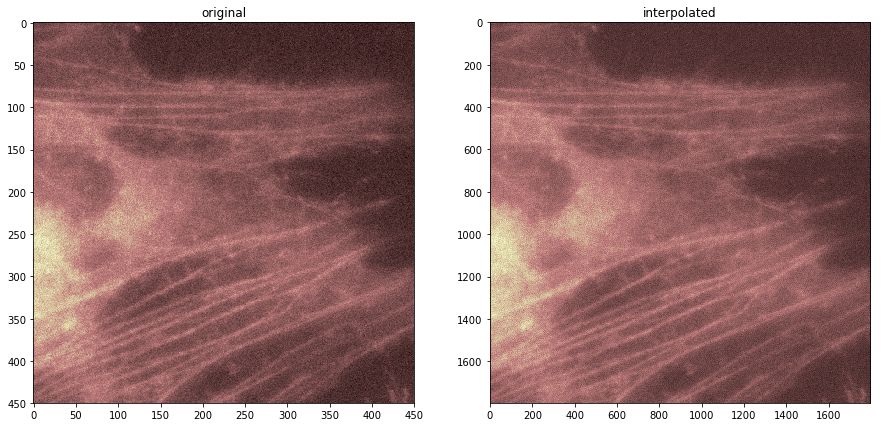

In [5]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(original_im,'pink')
plt.title('original')
plt.subplot(122)
plt.imshow(finterp_im[0][0],'pink')
plt.title('interpolated')


As we can see, the interpolated image reserved all the details of the original image, and increase the dimensions based on the interpolation factor. 



# 3. Use the <code>finterp.py</code> module for Fourier interpolation.

Another way to use the Fourier interpolation is to use it by directly importing the <code>finterp.py</code> module. You can pass the array and a list of interpolation factors to [<code>finterp.fourier_interp_array</code>](https://github.com/xiyuyi/pysofi/blob/master/functions/finterp.py). This step can be added at any stage of the analysis piipeline. The following scripts provide an example:



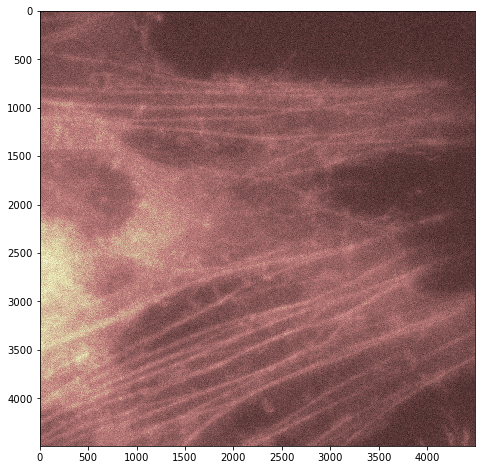

In [6]:
from functions import finterp # import the finterp module.

im = tiff.imread(filepath + '/' + filename, key=15) # read a frame
finterp_im2 = finterp.fourier_interp_array(im, [10]) # perform a 10-fold interpolation in the image.

# visualize the image
plt.figure(figsize = (8,8))
plt.imshow(finterp_im2[0], cmap='pink')